In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import matplotlib.pyplot as plt
import category_encoders as ce
from scipy import stats
import re
import warnings
import workalendar
from geopy.geocoders import ArcGIS
from geopy.distance import geodesic
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('punkt')
nltk.download('stopwords')
warnings.filterwarnings( 'ignore' )
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 200)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pliku\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pliku\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
hotels = pd.read_csv('data/hotels.csv')

*Дубликаты удалять не стану, по причинам описаным на вебинаре по проекту*

Посмотрю на количество неинформативных признаков:
* где содержание уникальных записей > 95%
* где содержание одинаковых записей > 95%

*Таких признаков я не найду*

In [3]:
# список для имён малоинформативных признаков
low_info = []

# цикл пройдёт по столбцам, вычислит долю уникальных значений и
# долю одинаковых значений в каждом признаке
for i in hotels.columns:
    same = hotels[i].value_counts(normalize=True).max()
    unique = hotels[i].nunique() / hotels[i].count()
    if same > 0.95:
        low_info.append(i)
        print(f'{i}: {same}')
    if unique > 0.95:
        low_info.append(i)
        print(f'{i}: {unique}')
        
print('Количество признаков с долей уникальных и однинаковых\n'
    f'записей > 0.95: {len(low_info)}')

Количество признаков с долей уникальных и однинаковых
записей > 0.95: 0


*Буду анализировать признак и, если требуется, преобразовывать. Возможно в связке с другими признаками*

# Адрес отеля, название отеля

*Выделю названия стран в которых расположены отели*

In [4]:
# уникальные значения стран
hotels['hotel_country'] = hotels['hotel_address'].apply(
    lambda x: 'United ' + x.split()[-1] if x.split()[-1] == 'Kingdom' else x.split()[-1]
    )

*Посмотрим на график и цифры*

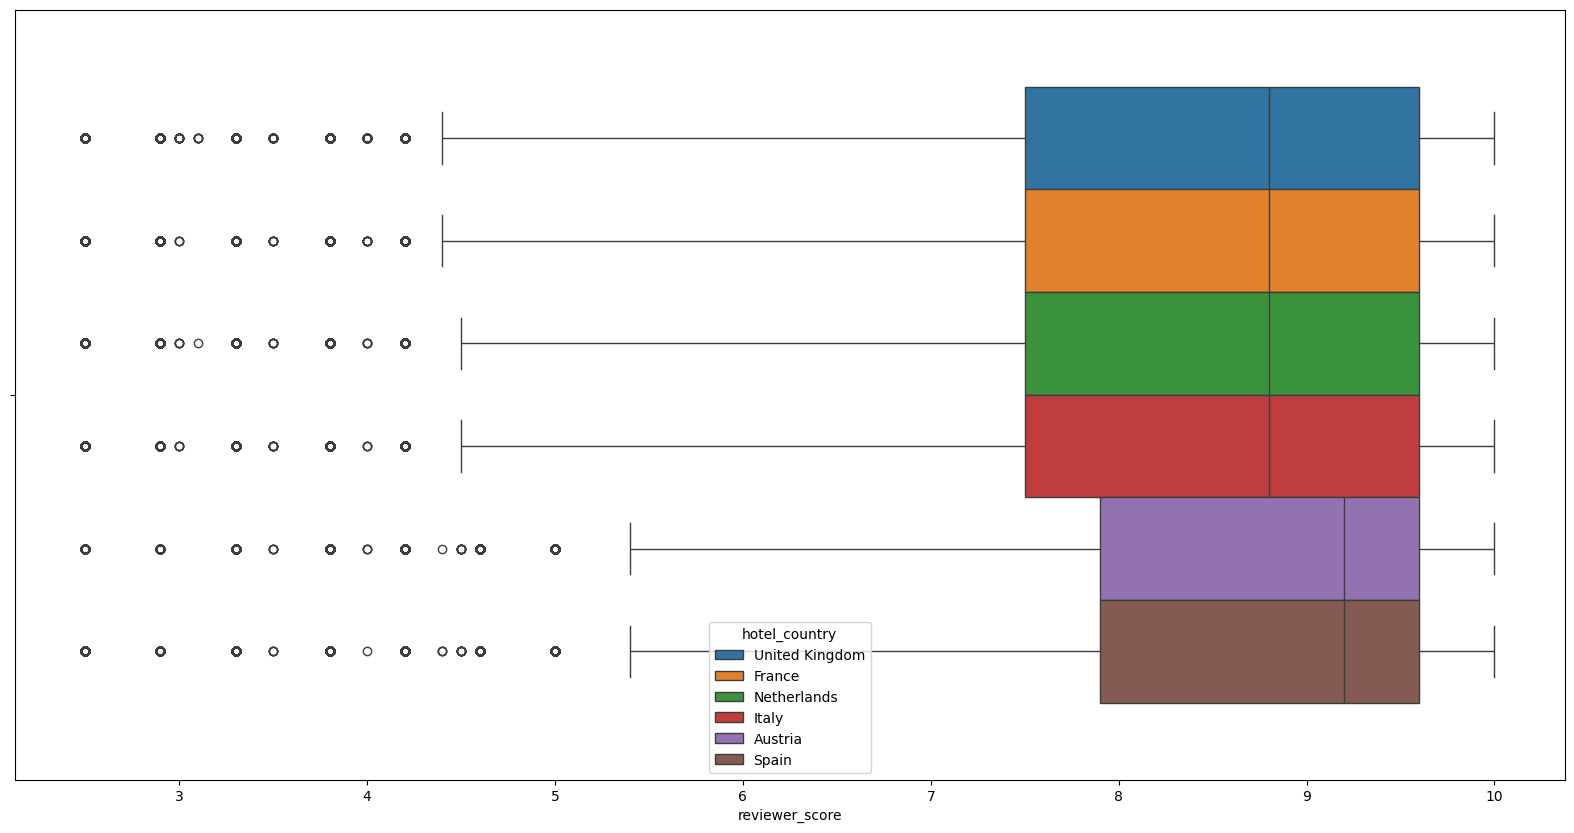

In [5]:
fig = plt.figure(figsize=(20, 10))

sns.boxplot(
    hotels,
    x='reviewer_score',
    hue='hotel_country',
);

In [6]:
hotels.groupby('hotel_country')['reviewer_score'].describe()

,count,mean,std,min,25%,50%,75%,max
hotel_country,,,,,,,,
Austria,29178.0,8.552642,1.507059,2.5,7.9,9.2,9.6,10.0
France,44830.0,8.420587,1.654414,2.5,7.5,8.8,9.6,10.0
Italy,27883.0,8.355482,1.639415,2.5,7.5,8.8,9.6,10.0
Netherlands,43006.0,8.449214,1.604041,2.5,7.5,8.8,9.6,10.0
Spain,45132.0,8.553747,1.555254,2.5,7.9,9.2,9.6,10.0
United Kingdom,196774.0,8.326884,1.669871,2.5,7.5,8.8,9.6,10.0


В Австрии и Испании медианные оценки и значения 25квартиля выше. Статистически значимо ли это и если да то какими факторами это обусловленно пока не ясно

*Заполню недостающие координаты*

In [7]:
# адреса отелей без привязки к координатам
addr = hotels[
    pd.isna(hotels.lat)
    ]['hotel_address'].value_counts().index

geolocator_arcgis = ArcGIS()

# цикл присваивает координаты по адресам
for i in addr:
    lat = round(geolocator_arcgis.geocode(i).latitude, 6)
    long = round(geolocator_arcgis.geocode(i).longitude, 6)
    hotels.loc[hotels['hotel_address'] == i, 'lat'] = lat
    hotels.loc[hotels['hotel_address'] == i, 'lng'] = long

*Сами по себе координаты не несут полезной нагрузки. Попробую посмотреть зависимость оценки от дистанции до центра города*

In [8]:
def distance(row):
    """В зависимости от расположения отеля функция вернёт
        дистанцию до центра города

    Args:
        row (_type_): строка в датафрейме, соответствующие столбцы

    Returns:
        geodesic: дистанция в километрах
    """
    if row['hotel_country'] == 'United Kingdom':
        return geodesic((51.500322, -0.140519), (row.lat, row.lng))
    elif row['hotel_country'] == 'France':
        return geodesic((48.858174, 2.294383), (row.lat, row.lng))
    elif row['hotel_country'] == 'Netherlands':
        return geodesic((52.373277, 4.892011), (row.lat, row.lng))
    elif row['hotel_country'] == 'Italy':
        return geodesic((45.464528, 9.188393), (row.lat, row.lng))
    elif row['hotel_country'] == 'Austria':
        return geodesic((48.209213, 16.370674), (row.lat, row.lng))
    else:
        return geodesic((41.386620, 2.170433), (row.lat, row.lng))

In [9]:
# применение функции и получение нового признака
hotels['distance'] = hotels.apply(lambda row: distance(row), axis=1)

# преобразование geodesic типа данных во float
hotels['distance'] = hotels['distance'].apply(
    lambda x: round(float(str(x).split()[0]), 4)
    )

*Посмотрим на зависимость оценки от дистанции до центра города*

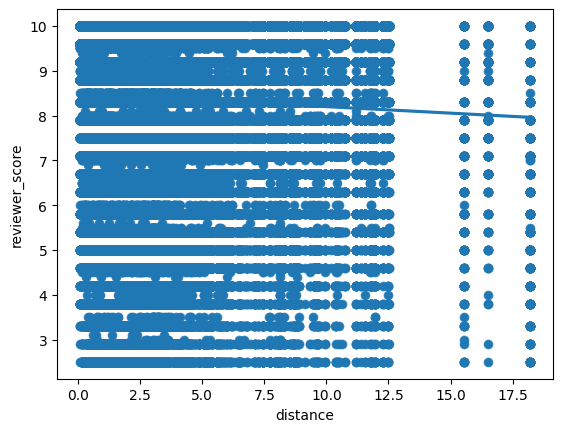

In [10]:
sns.scatterplot(
    hotels,
    x='distance',
    y='reviewer_score'
);

sns.regplot(
    hotels,
    x='distance',
    y='reviewer_score'
);

In [11]:
hotels['distance'].corr(hotels['reviewer_score'], 'spearman')

-0.07134996103234033

Слабенько как-то)

# Признак Национальность Ревьюера

*Поробую посмотреть зависимость оценок от того, является-ли ревьюер гражданином страны расположения отеля*

In [12]:
hotels['is_native'] = hotels.apply(
    lambda x: 1 if (x['reviewer_nationality']).strip() == x['hotel_country'] else 0,
    axis=1
    )

In [13]:
hotels.groupby('is_native')['reviewer_score'].describe()

,count,mean,std,min,25%,50%,75%,max
is_native,,,,,,,,
0,252862.0,8.385857,1.630714,2.5,7.5,8.8,9.6,10.0
1,133941.0,8.417766,1.645996,2.5,7.5,8.8,9.6,10.0


Тоже так себе результат=(

*Может быть сама национальность играет роль, посмотрим*

In [14]:
# удаление лишних пробелов
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(
    lambda x: x.strip()
)

# считаем табличку с привязкой стран к регионам
countries = pd.read_xml('https://www.artlebedev.ru/country-list/xml/')
countries.drop(index=0, axis=0, inplace=True)


Не все значения стран из левой таблицы совпадают со значениями из правой, потому 
я решил заранее создать словарь корректирующий эти значения в дальнейшем

In [15]:
# я уже заранее посмотрел какие страны нужно подкорректировать
missing = {
'United States of America': 'United States',
 'Russia': 'Russian Federation',
 'Iran': 'Iran, Islamic Republic of',
 'South Korea': "Korea, Democratic People's republic of",
 'Taiwan': 'Taiwan, Province of\xa0China',
 '': 'other',
 'Macedonia': 'Macedonia, The Former Yugoslav Republic Of',
 'Abkhazia Georgia': 'Abkhazia',
 'Brunei': 'Brunei Darussalam',
 'Macau': 'Macao',
 'Libya': 'Libyan Arab Jamahiriya',
 'Kosovo': 'Serbia',
 'Tanzania': 'Tanzania, United Republic\xa0Of',
 'Palestinian Territory': 'Palestinian Territory, Occupied',
 'Cura ao': 'Curaçao',
 'Syria': 'Syrian Arab Republic',
 'Ivory Coast': 'Guinea',
 'Bolivia': 'Bolivia, plurinational state\xa0of',
 'Turks Caicos': "Turks and Caicos Islands",
 'British Virgin Islands': 'British Indian Ocean Territory',
 'Antigua Barbuda': 'Antigua and Barbuda',
 'U S Virgin Islands': 'Virgin Islands, U.S.',
 'Swaziland': 'other',
 'Laos': "Lao People's Democratic Republic",
 'St Maarten': 'Saint Martin (French Part)',
 'Democratic Republic of the Congo': 'Congo, Democratic Republic of\xa0the',
 'Falkland Islands Malvinas': 'Falkland Islands (Malvinas)',
 'Crimea': 'Russian Federation',
 'East Timor': 'other',
 'Central Africa Republic': 'Central African Republic',
 'St Pierre and Miquelon': 'other',
 'Cocos K I': 'other',
 'Saint Martin': 'other',
 'Saint Vincent Grenadines': 'other',
 'Bonaire St Eustatius and Saba': 'other',
 'Svalbard Jan Mayen': 'other',
 'Saint Barts': 'other'
}

In [16]:
# корректируем несовпадающие значения
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(
    lambda x: missing[x] if x in missing else x
)

# объединение таблиц
hotels = hotels.merge(
    countries,
    how='left',
    left_on='reviewer_nationality',
    right_on='english'
)

# удалим ненужное
cols_to_drop = ['name', 'fullname', 'alpha2', 'alpha3', 'iso']
hotels.drop(cols_to_drop, axis=1, inplace=True)

# заполню оставшиеся значения как 'other'
hotels.fillna('other', inplace=True)

In [17]:
# заменим антарктику на others тк там всего 3 записи
hotels['english'] = hotels['english'].apply(
    lambda x: 'other' if x == 'Antarctica' else x
    )

hotels['location'] = hotels['location'].apply(
    lambda x: 'other' if x == 'Антарктика' else x
    )

hotels['location-precise'] = hotels['location-precise'].apply(
    lambda x: 'other' if x == ' ' else x
    )

In [18]:
# закодируем признак location
encoder = ce.OneHotEncoder(cols=['location'])
table = encoder.fit_transform(hotels['location'])
hotels = pd.concat([hotels, table], axis=1)

In [19]:
# таблица корреляции
hotels[[
    'reviewer_score', 'location_1', 'location_2', 
    'location_3', 'location_4', 'location_5', 'location_6'
    ]].corr('spearman')

,reviewer_score,location_1,location_2,location_3,location_4,location_5,location_6
reviewer_score,1.000000,0.005806,-0.075684,-0.017936,0.072884,0.023724,-0.007895
location_1,0.005806,1.000000,-0.616715,-0.202424,-0.488144,-0.342557,-0.050612
location_2,-0.075684,-0.616715,1.000000,-0.054364,-0.131098,-0.091998,-0.013593
location_3,-0.017936,-0.202424,-0.054364,1.000000,-0.043030,-0.030196,-0.004461
location_4,0.072884,-0.488144,-0.131098,-0.043030,1.000000,-0.072819,-0.010759
location_5,0.023724,-0.342557,-0.091998,-0.030196,-0.072819,1.000000,-0.007550
location_6,-0.007895,-0.050612,-0.013593,-0.004461,-0.010759,-0.007550,1.000000


In [20]:
hotels.groupby('location')['reviewer_score'].describe()

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
other,431.0,7.985383,1.802258,2.5,7.1,8.3,9.6,10.0
Азия,54962.0,8.088572,1.769841,2.5,7.1,8.3,9.6,10.0
Америка,36364.0,8.718689,1.518002,2.5,7.9,9.2,10.0,10.0
Африка,6781.0,8.207609,1.667528,2.5,7.5,8.8,9.6,10.0
Европа,269460.0,8.407930,1.621198,2.5,7.5,8.8,9.6,10.0
Океания,18805.0,8.595581,1.474702,2.5,7.9,9.2,9.6,10.0


Я так-же проверил признаки location-precise и reviewer_nationality, но по ним были ещё меньшие значения корреляций, потому я оставил закодированным только один признак. Хотя и по нему результаты не самые впечатляющие

# Признак дата

*Посмотрим что можно вытянуть из даты ревью*

In [21]:
# приводим признак к формату date-time
hotels['review_date'] = pd.to_datetime(hotels['review_date'])

# номер месяца
hotels['month_num'] = hotels['review_date'].dt.month

# номер дня недели
hotels['dow'] = hotels['review_date'].dt.day_of_week

# посмотрим на созависимость двух новых признаков
hotels.pivot_table(
    values='reviewer_score',
    index='dow',
    columns='month_num',
    aggfunc='median'
)

# стоит вывести из этих двух признаков один новый
hotels['day_group'] = hotels.apply(
    lambda x: x['dow'] * 12 + x['month_num'],
    axis=1
)

*Пожалуй здесь на этом всё. Я пробовал проверить ещё несколько теорий: зависимость от праздничных дней, сезонность*

*Так-же хотел проверить зависимость оценки от погоды во время проживания, но не смог технически реализовать парсинг данных с архивов погоды*

# Работа с признаком тэги

*Выделим некоторую информацию в отдельные бинарные признаки*

In [22]:
# список тэгов
tag_list = ['a']

# цикл для извлечения тэгов из признака
for i in hotels['tags'].to_list():
    tag_list.extend(i.replace("[' ", "").replace(" ']", "").split(" ', ' "))
    
# формат Series для оценки
tags = pd.Series(tag_list)

# преобразование признака с тэгами в удобный формат
hotels['tags'] = hotels['tags'].apply(
    lambda x: x.replace("[' ", "").replace(" ']", "").split(" ', ' ")
)

In [23]:
# поездка с целью отдыха
hotels['leisure'] = hotels['tags'].apply(
    lambda x: 1 if 'Leisure trip' in x else 0
)


# путешевствует один
hotels['lone'] = hotels['tags'].apply(
    lambda x: 1 if 'Solo traveler' in x else 0
)

# путешевствует пара
hotels['couple'] = hotels['tags'].apply(
    lambda x: 1 if 'Couple' in x else 0
)


# функция для поиска по тэгам для определения класса номера
def lux(x):
    expression = re.compile(
    "(?i)(\W|^)(Grand|Premier|View|Superior|Marvellous|Spa|Pool|Luxe|Deluxe|King|Queen|Lounge|Balcony)(\W|$)"
    )    
    if list(filter(expression.search, x)): return 1
    else: return 0
    
    
# класс номера
hotels['lux'] = hotels['tags'].apply(lux)

# функция для определения времени пребывания
def stay(x):
    z = [y for y in x if y.startswith('Stayed')]
    if z: return int(z[0].split()[1])
    else: return 0

# время пребывания в отле (ночей)
hotels['stayed'] = hotels['tags'].apply(stay)

*посмотирим на статистику*

In [24]:
df_corr = hotels[['leisure', 'lone',
       'couple', 'lux', 'reviewer_score']]
df_corr.corr(method='spearman')

,leisure,lone,couple,lux,reviewer_score
leisure,1.000000,-0.509337,0.275093,0.027070,0.115482
lone,-0.509337,1.000000,-0.504555,-0.047062,-0.086477
couple,0.275093,-0.504555,1.000000,0.095243,0.070432
lux,0.027070,-0.047062,0.095243,1.000000,0.071554
reviewer_score,0.115482,-0.086477,0.070432,0.071554,1.000000


# Работа с признаками тескстовые отзывы и количество слов в отзывах

In [25]:
# удаление лишних пробелов и приведение строки признака к нижнему регистру
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.strip().lower()
)

hotels['positive_review'] = hotels['positive_review'].apply(
    lambda x: x.strip().lower()
)

*Я уже проверил то, что количество слов в признаках "review_total_{}_word_counts" не соответствует фактическому количеству слов в отзыве, потому пересчитаем*

In [26]:
hotels['review_total_negative_word_counts'] = hotels[
    'negative_review'
    ].apply(lambda x: len(x.split()))

hotels['review_total_positive_word_counts'] = hotels[
    'positive_review'
    ].apply(lambda x: len(x.split()))

*Далее с помощью библиотеки NLTK получим очки эмоциональнольной окраски текста в отзывах*

In [27]:
# класс анализатора эмоциональной окраски текста
sia = SentimentIntensityAnalyzer()

In [28]:
# ниже две функции для получения признаков с суммарными очками окраски текста
# для признаков с негативными и с позитивными отзывами
def negative_review_scores(row):
    """Функция принимает строку датафрейма, далее в зависимости от количества
    слов и нахождения(отсутствия) в строке определённых знаков вернёт словарь
    с очками эмоциональной окраски

    Args:
        row (_type_): строка датафрейма

    Returns: (dict): словарь со значениями окраски
    """
    if row.review_total_negative_word_counts == 0: return {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.5423}
    elif row.review_total_negative_word_counts == 1:
        reg_1 = re.compile(("(?i)(\W|^)(nothing|none|nil|na|no|non)(\W|$)"))
        if reg_1.search(row.negative_review): return {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.5423}
        else: return sia.polarity_scores(row.negative_review)
    elif row.review_total_negative_word_counts == 2:
        reg_2 = re.compile(("(?i)(\W|^)(no negative|n a|nothing really|no complaints|absolutely nothing|not applicable|no negatives|no problems)(\W|$)"))
        if reg_2.search(row.negative_review): return {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.5423}
        else: return sia.polarity_scores(row.negative_review)
    elif row.review_total_negative_word_counts == 3:
        reg_3 = re.compile(("(?i)(\W|^)(nothing at all|nothing to dislike|nothing in particular|nothing to report|nothing to mention|nothing to say|nothing to complain)(\W|$)"))
        if reg_3.search(row.negative_review): return {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.5423}
        else: return sia.polarity_scores(row.negative_review)
    else: return sia.polarity_scores(row.negative_review)
    
    
def positive_review_scores(row):
    """Функция принимает строку датафрейма, далее в зависимости от количества
    слов и нахождения(отсутствия) в строке определённых знаков вернёт словарь
    с очками эмоциональной окраски

    Args:
        row (_type_): строка датафрейма

    Returns: (dict): словарь со значениями окраски
    """
    if row.review_total_positive_word_counts == 0: return {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5719}
    elif row.review_total_positive_word_counts == 1:
        reg_1 = re.compile(("(?i)(\W|^)(nothing|none|nil|na|no|non)(\W|$)"))
        if reg_1.search(row.positive_review): return {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5719}
        else: return sia.polarity_scores(row.positive_review)
    elif row.review_total_positive_word_counts == 2:
        reg_2 = re.compile(("(?i)(\W|^)(no positive)(\W|$)"))
        if reg_2.search(row.positive_review): return {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5719}
        else: return sia.polarity_scores(row.positive_review)
    else: return sia.polarity_scores(row.positive_review)
    
    
# применяем функции
hotels['negative_scores_summ'] = hotels.apply(negative_review_scores, axis=1)
hotels['positive_scores_summ'] = hotels.apply(positive_review_scores, axis=1)

# далее создаём отдельные признаки со значениями из суммарного признака
# для негативных отзывов
hotels['negative_neg_score'] = hotels['negative_scores_summ'].apply(lambda x: x['neg'])
hotels['negative_neu_score'] = hotels['negative_scores_summ'].apply(lambda x: x['neu'])
hotels['negative_pos_score'] = hotels['negative_scores_summ'].apply(lambda x: x['pos'])
hotels['negative_comp_score'] = hotels['negative_scores_summ'].apply(lambda x: x['compound'])

# для позитивных отзывов
hotels['positive_neg_score'] = hotels['positive_scores_summ'].apply(lambda x: x['neg'])
hotels['positive_neu_score'] = hotels['positive_scores_summ'].apply(lambda x: x['neu'])
hotels['positive_pos_score'] = hotels['positive_scores_summ'].apply(lambda x: x['pos'])
hotels['positive_comp_score'] = hotels['positive_scores_summ'].apply(lambda x: x['compound'])


*Признак "Количество дней с последнего отзыва" нужно перевести в формат инт*

In [29]:
hotels['days_since_review'] = hotels['days_since_review'].apply(
    lambda x: int(x.split()[0])
)

# Подготовка данных и построение модели

*Создам копию исходного датафрейма без текстовых и лишних столбцов*

In [30]:
hotels_copy = hotels[['additional_number_of_scoring',
       'average_score', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score',
       'days_since_review','distance',
       'is_native', 'location_1',
       'location_2', 'location_3', 'location_4', 'location_5', 'location_6',
       'month_num', 'dow', 'day_group', 'leisure', 'lone', 'couple', 'lux',
       'stayed',
       'negative_neg_score', 'negative_neu_score', 'negative_pos_score',
       'negative_comp_score', 'positive_neg_score', 'positive_neu_score',
       'positive_pos_score', 'positive_comp_score']]

In [31]:
X = hotels_copy.drop(['reviewer_score'], axis = 1)  
y = hotels_copy['reviewer_score']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42
    )

In [32]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=42)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)

print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.1s


MAPE: 0.12378905466553422


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   10.7s finished


MAPE: 0.12368806623950683